In [1]:
!pip install split-folders


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import os
import splitfolders
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [3]:
DATA_DIR = 'asl_dataset'
OUTPUT_DIR = 'asl_split_dataset' 

# splitfolders.ratio(DATA_DIR, output=OUTPUT_DIR, seed=42, ratio=(0.64, 0.16, 0.2))

In [9]:
IMAGE_SIZE = (224, 224, 3)  
BATCH_SIZE = 32
EPOCHS = 40
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.2

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

In [5]:
num_classes = 36

In [6]:
rescale_layer = tf.keras.layers.Rescaling(1./255)

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

Found 1581 files belonging to 36 classes.
Found 395 files belonging to 36 classes.
Found 539 files belonging to 36 classes.


In [8]:
train_dataset = train_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)
val_dataset = val_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)
test_dataset = test_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

In [10]:
base_model = MobileNet(input_shape=IMAGE_SIZE, include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,315,364 (16.46 MB)

 Trainable params: 1,086,500 (4.14 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=50,            
    restore_best_weights=True  
)

In [14]:
history_initial = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,  
    callbacks=[early_stopping],
    verbose=2 
)

Epoch 1/1000


50/50 - 17s - 342ms/step - accuracy: 0.7584 - loss: 0.7707 - val_accuracy: 0.7291 - val_loss: 0.7395
Epoch 2/1000
50/50 - 14s - 287ms/step - accuracy: 0.8476 - loss: 0.4993 - val_accuracy: 0.8177 - val_loss: 0.5225
Epoch 3/1000
50/50 - 15s - 304ms/step - accuracy: 0.9114 - loss: 0.2932 - val_accuracy: 0.8608 - val_loss: 0.3898
Epoch 4/1000
50/50 - 15s - 306ms/step - accuracy: 0.9355 - loss: 0.2211 - val_accuracy: 0.8911 - val_loss: 0.3192
Epoch 5/1000
50/50 - 15s - 298ms/step - accuracy: 0.9557 - loss: 0.1595 - val_accuracy: 0.8785 - val_loss: 0.3451
Epoch 6/1000
50/50 - 14s - 289ms/step - accuracy: 0.9620 - loss: 0.1291 - val_accuracy: 0.9139 - val_loss: 0.2760
Epoch 7/1000
50/50 - 15s - 293ms/step - accuracy: 0.9734 - loss: 0.0995 - val_accuracy: 0.9013 - val_loss: 0.2548
Epoch 8/1000
50/50 - 15s - 303ms/step - accuracy: 0.9728 - loss: 0.0914 - val_accuracy: 0.9063 - val_loss: 0.2528
Epoch 9/1000
50/50 - 15s - 308ms/step - accuracy: 0.9804 - loss: 0.0767 - val_accuracy: 0.8962 - val_

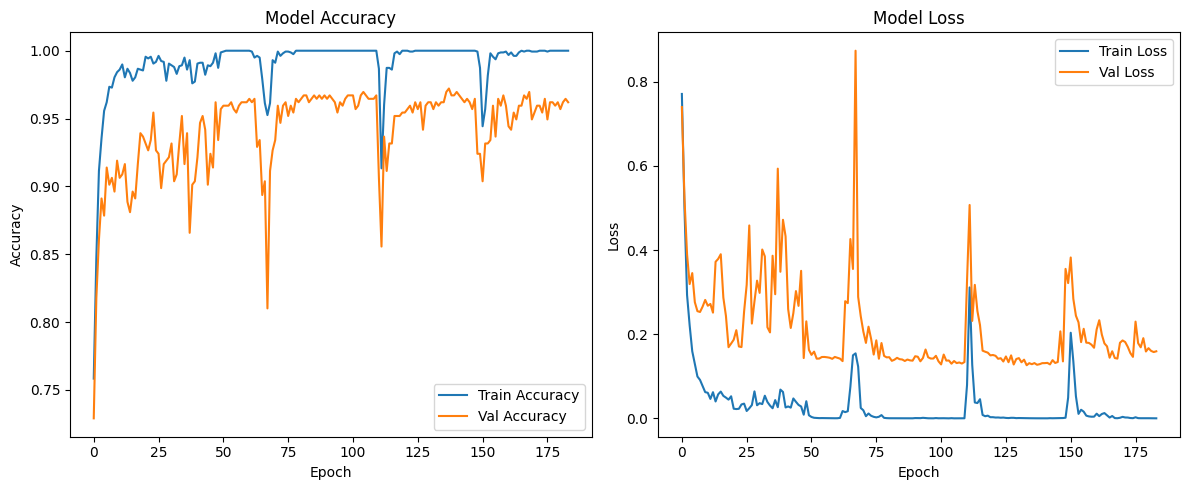

In [15]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history_initial)

In [16]:
for layer in base_model.layers[-20:]:  
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping_fine_tunning = EarlyStopping(
    monitor='val_loss',    
    patience=100,            
    restore_best_weights=True  
)

In [17]:
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2500,
    initial_epoch=history_initial.epoch[-1],  
    callbacks=[early_stopping],
    verbose=2  
)

Epoch 184/2500
50/50 - 26s - 511ms/step - accuracy: 0.5484 - loss: 3.6006 - val_accuracy: 0.9316 - val_loss: 0.2330
Epoch 185/2500
50/50 - 19s - 382ms/step - accuracy: 0.7236 - loss: 1.6035 - val_accuracy: 0.9089 - val_loss: 0.3942
Epoch 186/2500
50/50 - 19s - 381ms/step - accuracy: 0.8178 - loss: 0.8223 - val_accuracy: 0.9013 - val_loss: 0.4549
Epoch 187/2500
50/50 - 19s - 383ms/step - accuracy: 0.8887 - loss: 0.4155 - val_accuracy: 0.8987 - val_loss: 0.4411
Epoch 188/2500
50/50 - 19s - 380ms/step - accuracy: 0.9273 - loss: 0.2446 - val_accuracy: 0.9089 - val_loss: 0.4190
Epoch 189/2500
50/50 - 19s - 377ms/step - accuracy: 0.9488 - loss: 0.1650 - val_accuracy: 0.8987 - val_loss: 0.4014
Epoch 190/2500
50/50 - 19s - 381ms/step - accuracy: 0.9633 - loss: 0.1172 - val_accuracy: 0.8962 - val_loss: 0.3885
Epoch 191/2500
50/50 - 19s - 378ms/step - accuracy: 0.9690 - loss: 0.0910 - val_accuracy: 0.9114 - val_loss: 0.3763
Epoch 192/2500
50/50 - 22s - 430ms/step - accuracy: 0.9722 - loss: 0.069

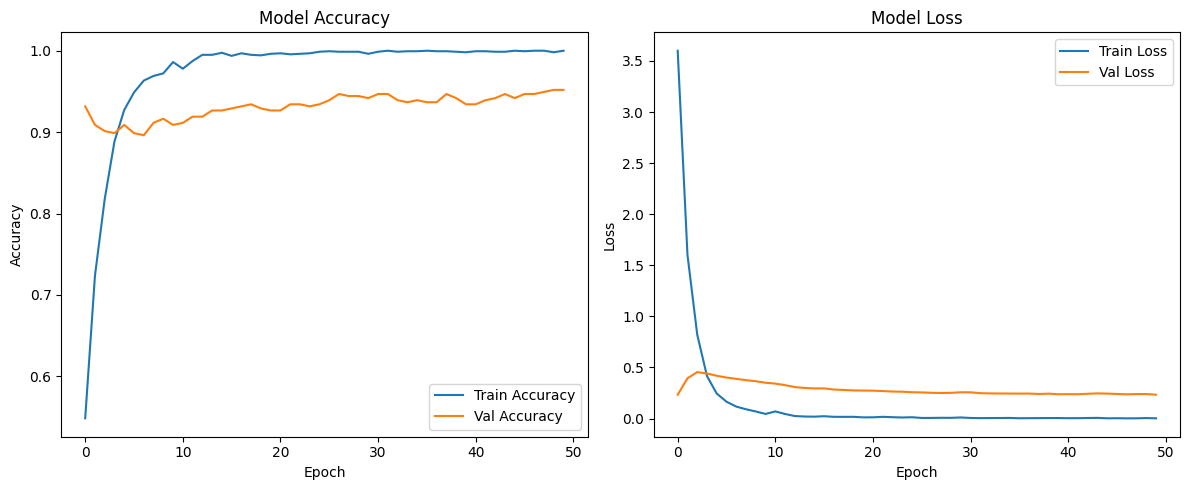

In [18]:
plot_training_history(history_fine_tune)

In [20]:
model.save('fine_tuned_model2.keras')

In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.9608 - loss: 0.1131
Test Accuracy: 94.62%
Test Loss: 0.1577
